In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

In [205]:
df=pd.read_csv('heart_disease.csv')

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


age: age in years


sex: (1 = male; 0 = female)


cp: chest pain type


trestbps: resting blood pressure 


chol:serum cholestoral in mg/dl


fbs: fasting blood sugar (1 = true; 0 = false)


restecg: resting electrocardiographic results

thalach: maximum heart rate achieved

exang: exercise induced angina (1 = yes; 0 = no)

oldpeak: ST depression induced by exercise relative to rest

ca: Number of major vessels

In [207]:
df['target'].value_counts()

target
1    165
0    138
Name: count, dtype: int64

In [208]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [209]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


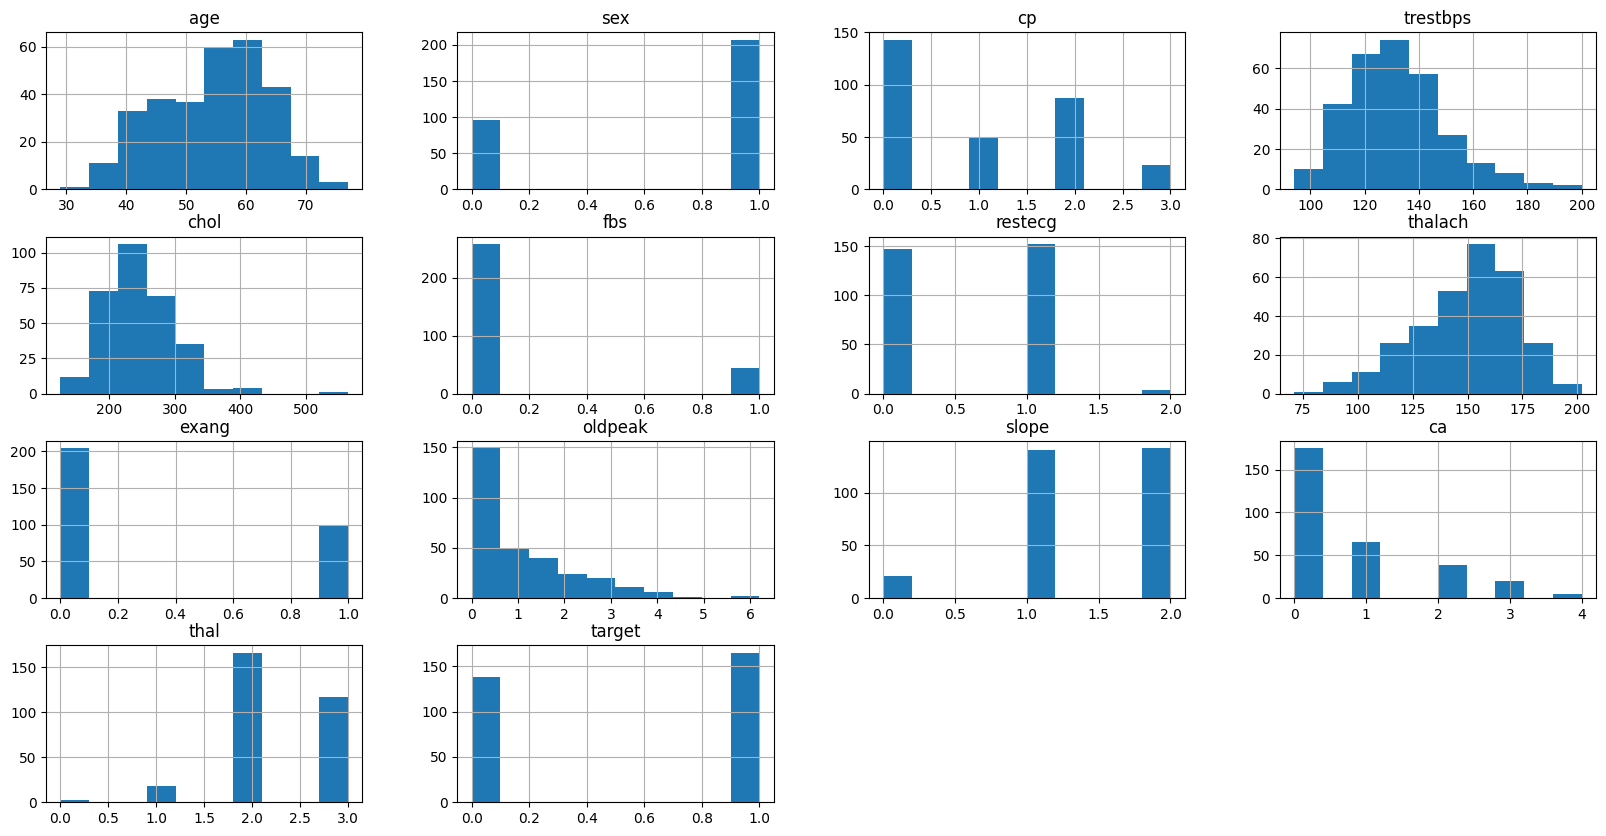

In [210]:
# see the distribution of the data
df.hist(figsize=(20, 10))
plt.show()

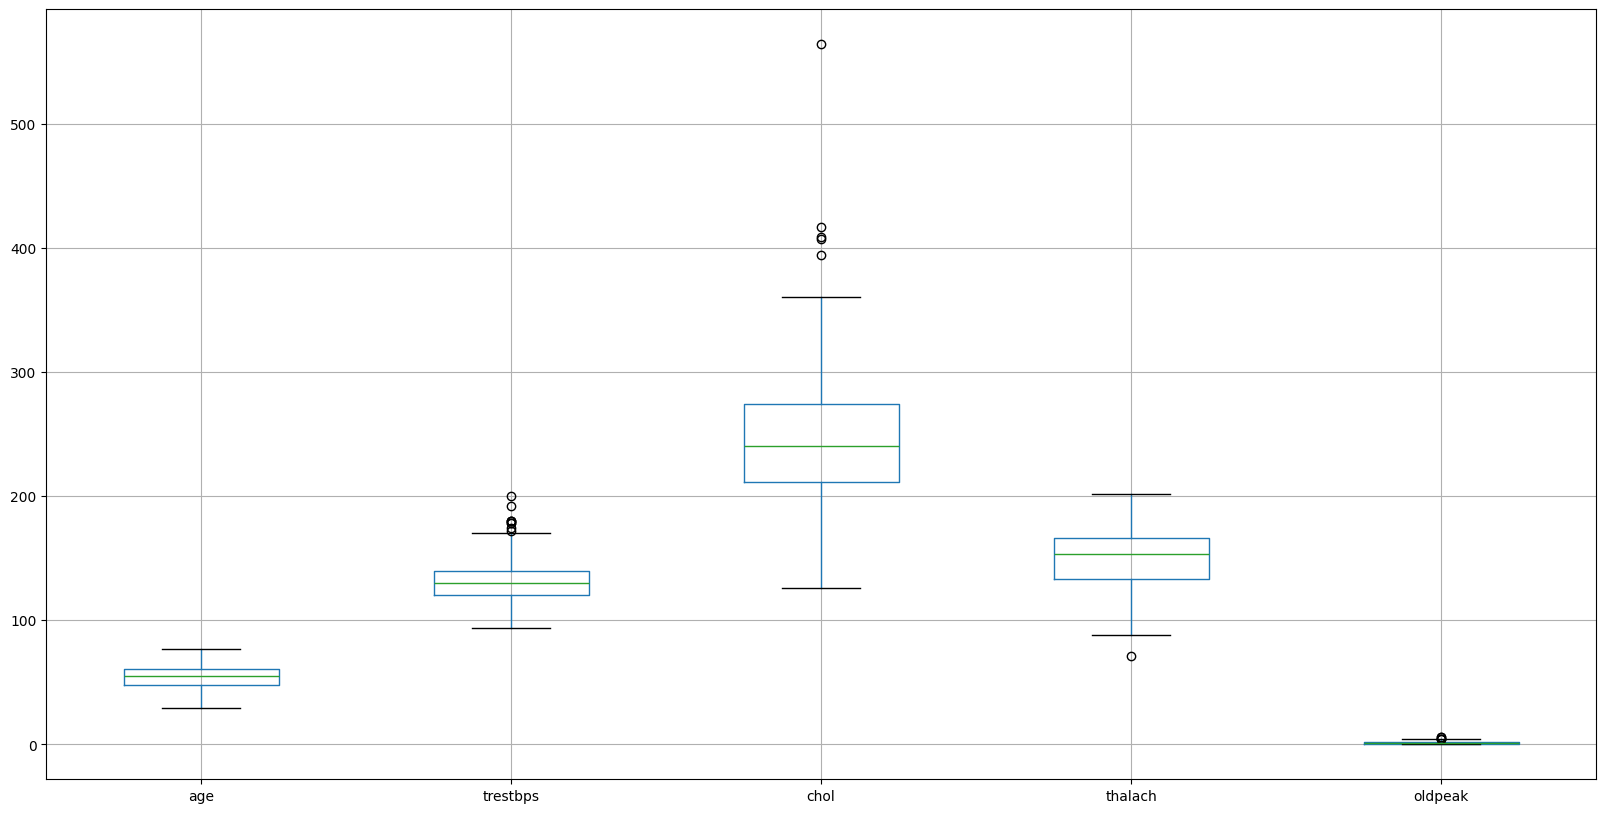

In [211]:
# see the data outliers
outliers = df[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']]
outliers.boxplot(figsize=(20, 10))
plt.show()

In [212]:
columns_to_check = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Function to count outliers using IQR
def count_outliers_iqr(df, columns):
    outlier_counts = {}
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_counts[column] = len(outliers)
    return outlier_counts

outliers_iqr = count_outliers_iqr(df, columns_to_check)
print("Outliers in each column:", outliers_iqr)

Outliers in each column: {'age': 0, 'trestbps': 9, 'chol': 5, 'thalach': 1, 'oldpeak': 5}


In [213]:
#cap outliers using IQR replacing them with the lower and upper bound
def cap_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

df = cap_outliers(df, columns_to_check)

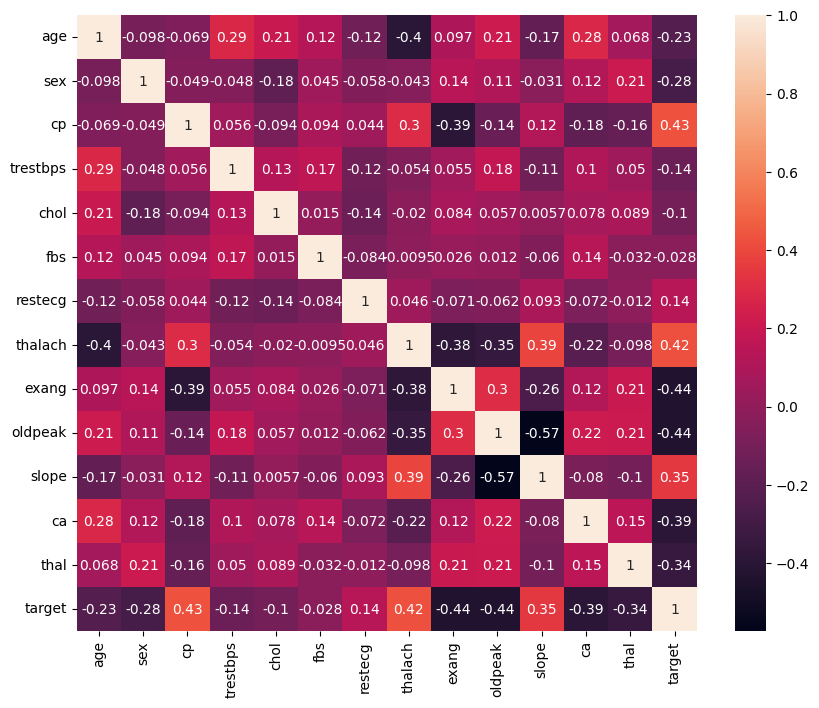

In [214]:
# see the correlation between the columns
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True)
plt.show()

## Splitting the data

In [215]:
x=df.drop('target', axis=1)
y=df['target']

## Trying different models

In [216]:
#Random Forest Classifier

#RandomForestClassifier does not require scaling because it is a tree-based model. 
#Tree-based models split data based on feature values, so they are insensitive to scaling
n = 50
forest_accuracy = []
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=i, stratify=y)
    random_forest = RandomForestClassifier()
    random_forest.fit(X_train, y_train)

    y_pred = random_forest.predict(X_test)
    forest_accuracy.append(accuracy_score(y_test, y_pred))

# see the average accuracy of random_forest Classifier
print('Average accuracy of random_forest Classifier:', np.mean(forest_accuracy))

Average accuracy of random_forest Classifier: 0.8170491803278689


In [217]:
#XGBoost Classifier

#XGBoost is a tree-based model, meaning it does not require feature scaling.
n = 50
XGBoost_accuracy = []
for i in range(n):
   
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=i, stratify=y)
   
    xgboost = XGBClassifier()
    xgboost.fit(X_train, y_train)
    y_pred = xgboost.predict(X_test)
    XGBoost_accuracy.append(accuracy_score(y_test, y_pred))

# see the average accuracy of XGBoost Classifier
print('Average accuracy of XGBoost Classifier:', np.mean(XGBoost_accuracy))

Average accuracy of XGBoost Classifier: 0.7904918032786885


In [218]:
# GaussianNB Classifier
n = 50
G_accuracy = []
for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=i, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    G = GaussianNB()
    G.fit(X_train_scaled, y_train)
    X_test_scaled = scaler.transform(X_test)
    y_pred = G.predict(X_test_scaled)
    G_accuracy.append(accuracy_score(y_test, y_pred))

# see the average accuracy of GaussianNB Classifier
print('Average accuracy of GaussianNB Classifier:', np.mean(G_accuracy))

Average accuracy of GaussianNB Classifier: 0.8288524590163934


In [219]:
# Support Vector Classifier

n = 50
svc_accuracy = []

for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=i, stratify=y)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    svc = SVC(kernel='linear')
    svc.fit(X_train_scaled, y_train)
    
    y_pred = svc.predict(X_test_scaled)
    svc_accuracy.append(accuracy_score(y_test, y_pred))

# See the average accuracy of the SVC Classifier
print('Average accuracy of SVC Classifier:', np.mean(svc_accuracy))


Average accuracy of SVC Classifier: 0.8393442622950819


In [220]:
# KNN Classifier
n = 50
knn_accuracy = []

for i in range(n):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=i, stratify=y)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)   

    knn = KNeighborsClassifier(n_neighbors=5)  
    knn.fit(X_train_scaled, y_train)

    y_pred = knn.predict(X_test_scaled)
    knn_accuracy.append(accuracy_score(y_test, y_pred))

# See the average accuracy of the KNN Classifier
print('Average accuracy of KNN Classifier:', np.mean(knn_accuracy))

Average accuracy of KNN Classifier: 0.8242622950819672


As it shows after trying different models the best model is SVM so the next step is hyperparameter tunning for the model


## Hyperparameter tunning

In [221]:
from sklearn.model_selection import GridSearchCV


# Hyperparameters to tune
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'kernel': ['linear', 'rbf', 'poly'],  # Different kernel functions
    'gamma': ['scale', 'auto', 0.1, 1],  # Kernel coefficient
    'degree': [3, 4, 5],  # Degree for polynomial kernel
    'class_weight': [None, 'balanced']  # Handle class imbalance
}

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svc = SVC()

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# Evaluate the best model on test data
best_svc = grid_search.best_estimator_
y_pred = best_svc.predict(X_test_scaled)

# Accuracy on test data
print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")


Best parameters: {'C': 1, 'class_weight': 'balanced', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score: 0.8474489795918367
Test accuracy: 0.819672131147541


Save the model

In [222]:
# save scaler
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [223]:
# save model
joblib.dump(grid_search, 'model.pkl')

['model.pkl']